In [ ]:
import os
import numpy as np
import tensorflow as tf
import shutil
import glob as glob
import cv2
import matplotlib.pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/mu2mech_final_data_10.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_90.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_100.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_110.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_120.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_130.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_140.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_150.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_160.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_170.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_180.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_190.00.png  
  inflating: /content/mu2mech_final_data/10time_step/0.43%/output_200.00.png  
  

In [ ]:
train_images_list = []
from tkinter import Tcl

compositions = ['0.37%', '0.4%', '0.43%', '0.45%', '0.47%', '0.5%','0.35%', '0.25%', '0.3%', '0.33%']


for i in range(0,2):
  comp = compositions[i]
  X_train = glob.glob("/content/mu2mech_final_data/1time_step/" + comp +"/*.png")
  X_train = Tcl().call('lsort', '-dict', X_train)
  X_train = X_train[500:1000]
  for img in X_train:
    train_images_list.append(img)

#printing the number of images
print(len(train_images_list))
#1k images

#printing the dimensions
img = cv2.imread(train_images_list[0])
dims = img.shape
print(dims)


1000
(128, 128, 3)


In [ ]:
#Reshaping the image into proper input dormat for the autoencoder
from PIL import Image

train_images= []

for i,path in enumerate(train_images_list):
  image = cv2.imread(train_images_list[i],cv2.COLOR_BGR2RGB)
  img = np.array(image)
  img = img.astype("float32")/255.
  train_images.append(img)

print(len(train_images))
print(train_images[0].shape)

1000
(128, 128, 3)


In [ ]:
train_images = np.array(train_images)

(800, 128, 128, 3)
(100, 128, 128, 3)


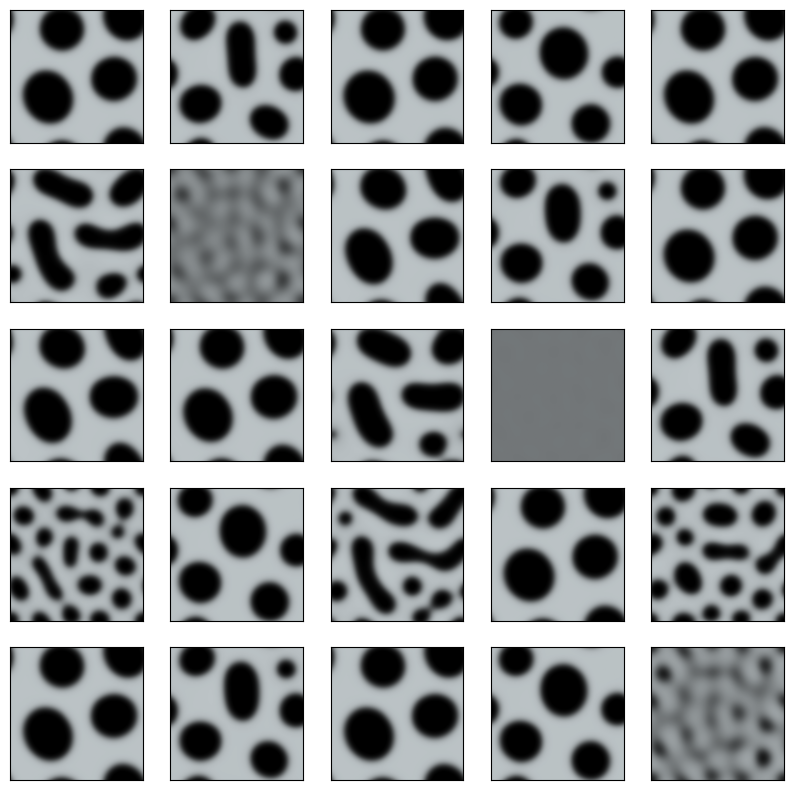

In [ ]:
from sklearn.model_selection import train_test_split

#dividing into train and test sets

train_data, test_data = train_test_split(train_images, train_size=0.8, test_size=0.1, random_state=42, shuffle=True)
print(train_data.shape)

print(test_data.shape)
#plotting the figures of the train set

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i])
plt.show()


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# from keras.layers.preprocessing import string_lookup
model = tf.keras.Sequential()

#Designing the encoder section of the model
model.add(tf.keras.layers.Conv2D(input_shape = (128,128,3), filters= 64, kernel_size = (5,5), activation='sigmoid', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='sigmoid', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=(5,5), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

# (32,32,8)

#Deigning the Decoder section of the model

model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=(5,5), activation='relu', padding='same'))
model.add(tf.keras.layers.UpSampling2D((2,2)))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='sigmoid', padding='same'))
model.add(tf.keras.layers.UpSampling2D((2,2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5),  activation='sigmoid', padding='same'))
model.add(tf.keras.layers.UpSampling2D((2,2)))

model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        9232      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 4)         1604      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 4)        0

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# 1 - 87%
# 2 - 88%
# 3 - 89%
# 4 - 90%

checkpoint_filepath = '/content/drive/MyDrive/New_models_Mu2Mech/1th_time_step/Reconstruction_model_5/autoencoder.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [ ]:
history = model.fit(train_data,
                    train_data,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=8,
                    verbose=1,
                    shuffle=True,
                    callbacks=[model_checkpoint_callback,early_stopping, reduce_lr])

Epoch 1/100
80/80 [==============================] - 4s 23ms/step - loss: 0.0576 - accuracy: 0.4514 - val_loss: 0.0130 - val_accuracy: 0.7678 - lr: 0.0010
Epoch 2/100
80/80 [==============================] - 1s 16ms/step - loss: 0.0077 - accuracy: 0.7532 - val_loss: 0.0054 - val_accuracy: 0.7788 - lr: 0.0010
Epoch 3/100
80/80 [==============================] - 1s 16ms/step - loss: 0.0040 - accuracy: 0.7894 - val_loss: 0.0032 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 4/100
80/80 [==============================] - 1s 17ms/step - loss: 0.0026 - accuracy: 0.8116 - val_loss: 0.0024 - val_accuracy: 0.8283 - lr: 0.0010
Epoch 5/100
80/80 [==============================] - 1s 16ms/step - loss: 0.0019 - accuracy: 0.8300 - val_loss: 0.0018 - val_accuracy: 0.8436 - lr: 0.0010
Epoch 6/100
80/80 [==============================] - 1s 16ms/step - loss: 0.0016 - accuracy: 0.8382 - val_loss: 0.0016 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 7/100
80/80 [==============================] - 1s 16ms/step - lo

KeyboardInterrupt: ignored

In [ ]:
preds = model.predict(test_data)

8/8 [==============================] - 2s 96ms/step


In [ ]:
score = model.evaluate(preds, test_data)

8/8 [==============================] - 0s 27ms/step - loss: 4.7645e-04 - accuracy: 0.8848
